In [2]:
pip install dill

  Using cached https://files.pythonhosted.org/packages/52/d6/79f40d230895fa1ce3b6af0d22e0ac79c65175dc069c194b79cc8e05a033/dill-0.3.3-py2.py3-none-any.whl
requests 2.25.1 has requirement idna<3,>=2.5, but you'll have idna 3.1 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
`initjs()`

SyntaxError: invalid syntax (<ipython-input-24-7c86cdaa84e5>, line 1)

In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import time
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import dill
import pickle
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shap


In [37]:
random_seed = 123


print("start")

df_eco = pd.read_csv('./Datasets/Marginal_Combined_60.csv', sep=',', encoding='utf-8')
print(df_eco.head())


start
   Unnamed: 0   FIPS  unclassified_indoor_fungi  \
0           1  35001                       3445   
1           2  35001                       3081   
2           3  35001                       5112   
3           4  35001                       2513   
4           5  35001                       3523   

   k__Fungi.p__Ascomycota.c__Eurotiomycetes.o__Eurotiales.f__Trichocomaceae.g__Aspergillus_indoor  \
0                                                 17                                                
1                                                 36                                                
2                                                380                                                
3                                                 14                                                
4                                                 18                                                

   k__Fungi.p__Ascomycota.c__Dothideomycetes.o__Capnodiales.f__Incertae.sedis.g_

In [38]:
print(df_eco.describe())

        Unnamed: 0          FIPS  unclassified_indoor_fungi  \
count  1280.000000   1280.000000                1280.000000   
mean    640.500000  30900.017188                1917.315625   
std     369.648482  15343.245532                1051.002528   
min       1.000000   1009.000000                   0.000000   
25%     320.750000  18157.500000                1452.250000   
50%     640.500000  36037.000000                2019.500000   
75%     960.250000  42004.000000                2502.500000   
max    1280.000000  56001.000000                7524.000000   

       k__Fungi.p__Ascomycota.c__Eurotiomycetes.o__Eurotiales.f__Trichocomaceae.g__Aspergillus_indoor  \
count                                        1280.000000                                                
mean                                          557.350000                                                
std                                          1294.997779                                                
min         

In [39]:
y = df_eco['IFR']
print(y)

print("df_eco "+str(df_eco.shape))

X = df_eco.iloc[:,:-1]

print("X "+str(X.shape))

0       0.005300
1       0.005300
2       0.005300
3       0.005300
4       0.005300
          ...   
1275    0.005783
1276    0.003057
1277    0.005040
1278    0.006855
1279    0.001111
Name: IFR, Length: 1280, dtype: float64
df_eco (1280, 429)
X (1280, 428)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed) #, random_state=9# The seed was 'chosen' so test and training contain all labels: rn=3,4,8,9
print("train label deficit:",len(set(y)-set(y_train)),"test label deficit:",len(set(y)-set(y_test)))

print("shapes "+str(X_train.shape)+"\t"+str(X_test.shape)+"\t"+str(y_train.shape)+"\t"+str(y_test.shape))

train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

input_data_dump = [X, y, X_train, X_test, y_train, y_test]
pickle.dump(input_data_dump,open("input_data_dump", "wb" ) )

train label deficit: 62 test label deficit: 265
shapes (960, 428)	(320, 428)	(960,)	(320,)


In [43]:
modelstart = time.time()

print(f"Starting search at {modelstart}")
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 200,
                             verbose = 5,
                             learning_rate = 0.1,
                             depth = 3,
                             l2_leaf_reg = 0.5,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

grid = {#'iterations': [100, 150, 200],
       'learning_rate': [0.07, 0.08, 0.1],
        'depth': [3, 4, 5],
        'l2_leaf_reg': [3.5, 4, 5, 6,7]}
grid_search_result = cb_model.grid_search(grid, train_dataset)

lr = grid_search_result['params']['learning_rate']
de = grid_search_result['params']['depth']
l2 = grid_search_result['params']['l2_leaf_reg']

print(f"Trained grid search in {time.time() - modelstart}s")

print("lr, de, l2 "+str(lr)+", "+str(de)+", "+str(l2))





Starting search at 1615449373.866528

bestTest = 0.0009872718477
bestIteration = 199

0:	loss: 0.0009873	best: 0.0009873 (0)	total: 1.66s	remaining: 43.1s

bestTest = 0.0009957521612
bestIteration = 198

1:	loss: 0.0009958	best: 0.0009873 (0)	total: 3.14s	remaining: 39.2s

bestTest = 0.001011161549
bestIteration = 175

2:	loss: 0.0010112	best: 0.0009873 (0)	total: 4.71s	remaining: 37.7s

bestTest = 0.001006217008
bestIteration = 199

3:	loss: 0.0010062	best: 0.0009873 (0)	total: 6.21s	remaining: 35.7s

bestTest = 0.0009922646174
bestIteration = 199

4:	loss: 0.0009923	best: 0.0009873 (0)	total: 7.97s	remaining: 35.1s

bestTest = 0.0009845294712
bestIteration = 190

5:	loss: 0.0009845	best: 0.0009845 (5)	total: 9.44s	remaining: 33.1s

bestTest = 0.001005154458
bestIteration = 199

6:	loss: 0.0010052	best: 0.0009845 (5)	total: 11.4s	remaining: 32.5s

bestTest = 0.0009830565978
bestIteration = 196

7:	loss: 0.0009831	best: 0.0009831 (7)	total: 12.9s	remaining: 30.6s

bestTest = 0.00097302

In [10]:
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 1000,
                             verbose = 5,
                             learning_rate = lr,
                             depth = de,
                             l2_leaf_reg = l2,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

print(f"Starting search at {modelstart}")
cbmf = cb_model.fit(X_train,y_train)
print(f"Trained in {time.time() - modelstart}s")

0:	learn: 0.0025929	total: 6.42ms	remaining: 6.41s
5:	learn: 0.0021728	total: 31.7ms	remaining: 5.26s
10:	learn: 0.0019245	total: 54.8ms	remaining: 4.92s
15:	learn: 0.0017671	total: 78.2ms	remaining: 4.81s
20:	learn: 0.0016651	total: 104ms	remaining: 4.83s
25:	learn: 0.0015911	total: 129ms	remaining: 4.83s
30:	learn: 0.0015317	total: 152ms	remaining: 4.75s
35:	learn: 0.0014831	total: 175ms	remaining: 4.7s
40:	learn: 0.0014463	total: 198ms	remaining: 4.64s
45:	learn: 0.0014029	total: 223ms	remaining: 4.62s
50:	learn: 0.0013599	total: 248ms	remaining: 4.62s
55:	learn: 0.0013245	total: 273ms	remaining: 4.61s
60:	learn: 0.0012903	total: 296ms	remaining: 4.56s
65:	learn: 0.0012591	total: 319ms	remaining: 4.52s
70:	learn: 0.0012169	total: 343ms	remaining: 4.48s
75:	learn: 0.0011865	total: 366ms	remaining: 4.44s
80:	learn: 0.0011518	total: 392ms	remaining: 4.44s
85:	learn: 0.0011229	total: 415ms	remaining: 4.41s
90:	learn: 0.0010916	total: 441ms	remaining: 4.4s
95:	learn: 0.0010579	total: 465

795:	learn: 0.0001133	total: 3.88s	remaining: 994ms
800:	learn: 0.0001117	total: 3.9s	remaining: 970ms
805:	learn: 0.0001106	total: 3.93s	remaining: 946ms
810:	learn: 0.0001093	total: 3.96s	remaining: 922ms
815:	learn: 0.0001077	total: 3.99s	remaining: 899ms
820:	learn: 0.0001063	total: 4.01s	remaining: 876ms
825:	learn: 0.0001048	total: 4.04s	remaining: 851ms
830:	learn: 0.0001037	total: 4.06s	remaining: 826ms
835:	learn: 0.0001027	total: 4.08s	remaining: 802ms
840:	learn: 0.0001012	total: 4.11s	remaining: 777ms
845:	learn: 0.0000996	total: 4.13s	remaining: 753ms
850:	learn: 0.0000986	total: 4.16s	remaining: 728ms
855:	learn: 0.0000975	total: 4.18s	remaining: 704ms
860:	learn: 0.0000960	total: 4.21s	remaining: 679ms
865:	learn: 0.0000948	total: 4.23s	remaining: 655ms
870:	learn: 0.0000933	total: 4.25s	remaining: 630ms
875:	learn: 0.0000920	total: 4.28s	remaining: 606ms
880:	learn: 0.0000910	total: 4.31s	remaining: 582ms
885:	learn: 0.0000898	total: 4.34s	remaining: 559ms
890:	learn: 0

In [11]:
pred_train = cb_model.predict(X_train)
rmseT = (np.sqrt(mean_squared_error(y_train, pred_train)))
r2T = r2_score(y_train, pred_train)
print("Testing performance:")
print('RMSE training: {:.2f}'.format(rmseT))
print('R2 training: {:.2f}'.format(r2T))


Testing performance:
RMSE training: 0.00
R2 training: 1.00


In [12]:
cbmf.feature_names = df_eco.columns[:-1]

In [13]:
pred_test = cb_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_test)))
r2 = r2_score(y_test, pred_test)
print("Testing performance:")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))


Testing performance:
RMSE: 0.00
R2: 0.79


In [14]:
explainer_model = shap.TreeExplainer(cb_model)
explainer_fit = shap.TreeExplainer(cbmf)

In [16]:
data_output = [random_seed, cb_model, cbmf, pred_train, explainer_model, pred_test, explainer_fit]
pickle.dump(data_output,open("data_output_MAE", "wb" ) )


Text(0.5, 0, 'CatBoost Feature Importance')

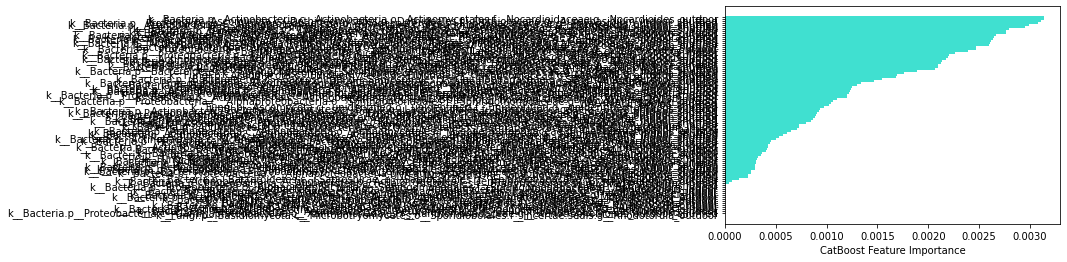

In [17]:
sorted_feature_importance = cb_model.feature_importances_.argsort()
plt.barh(cb_model.feature_names[sorted_feature_importance[1:100]],
        cb_model.feature_importances_[sorted_feature_importance[1:100]],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

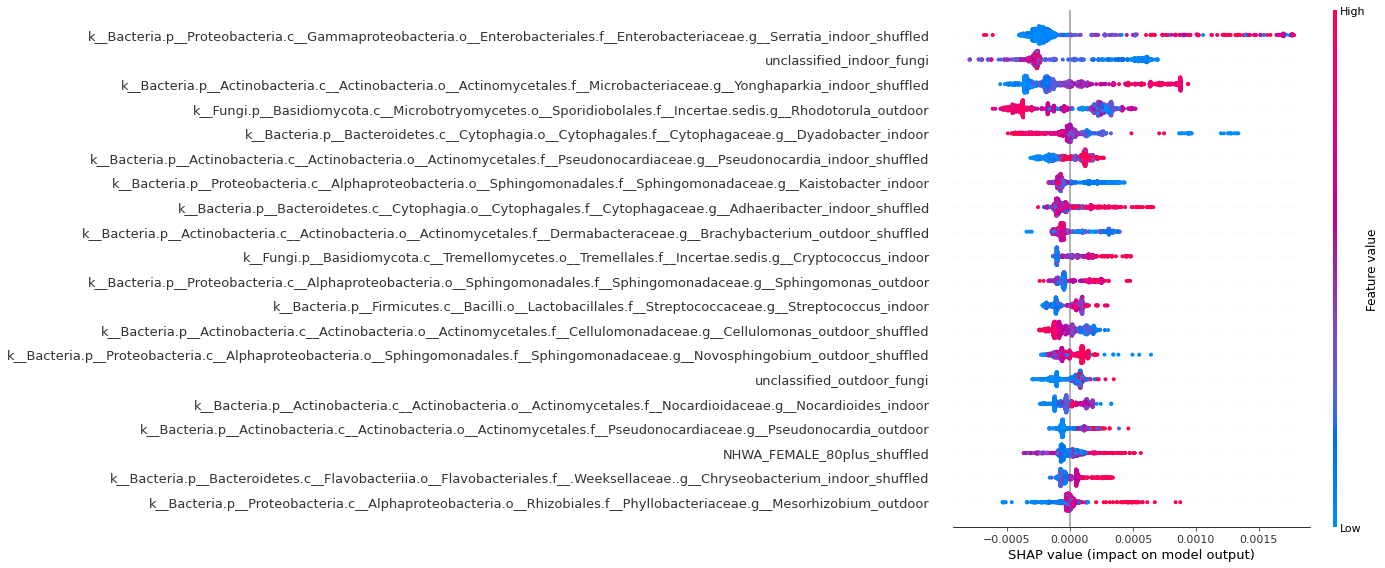

In [26]:
shap_values = explainer_model.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')


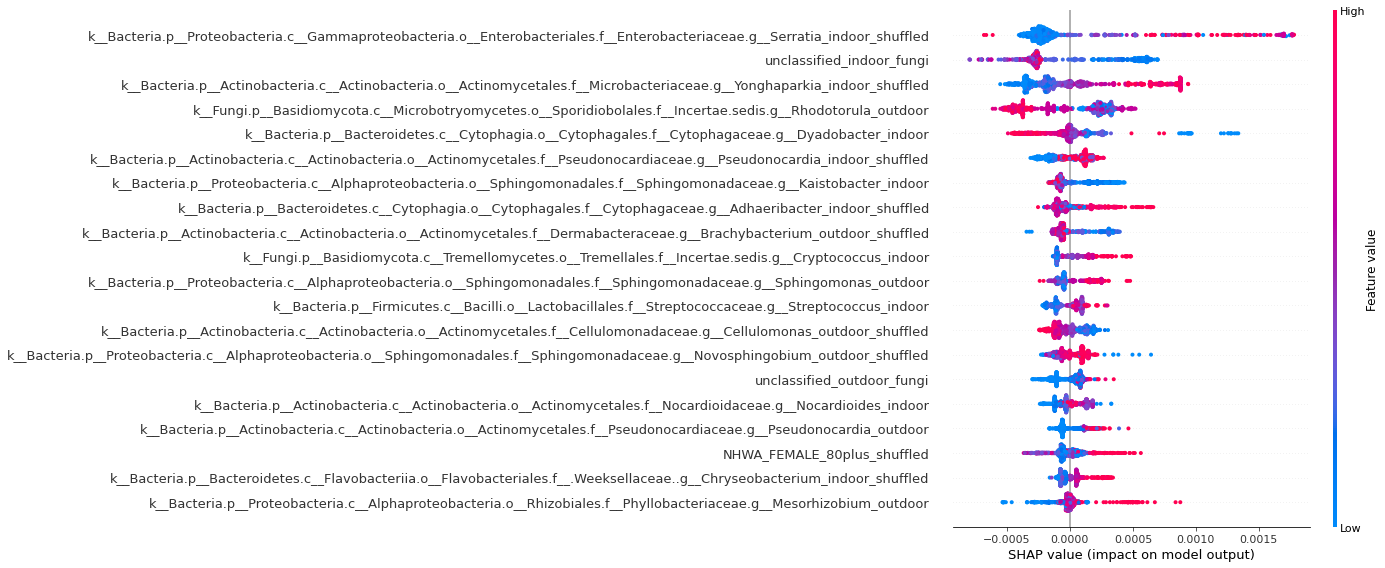

In [28]:
shap_values = explainer_fit.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')



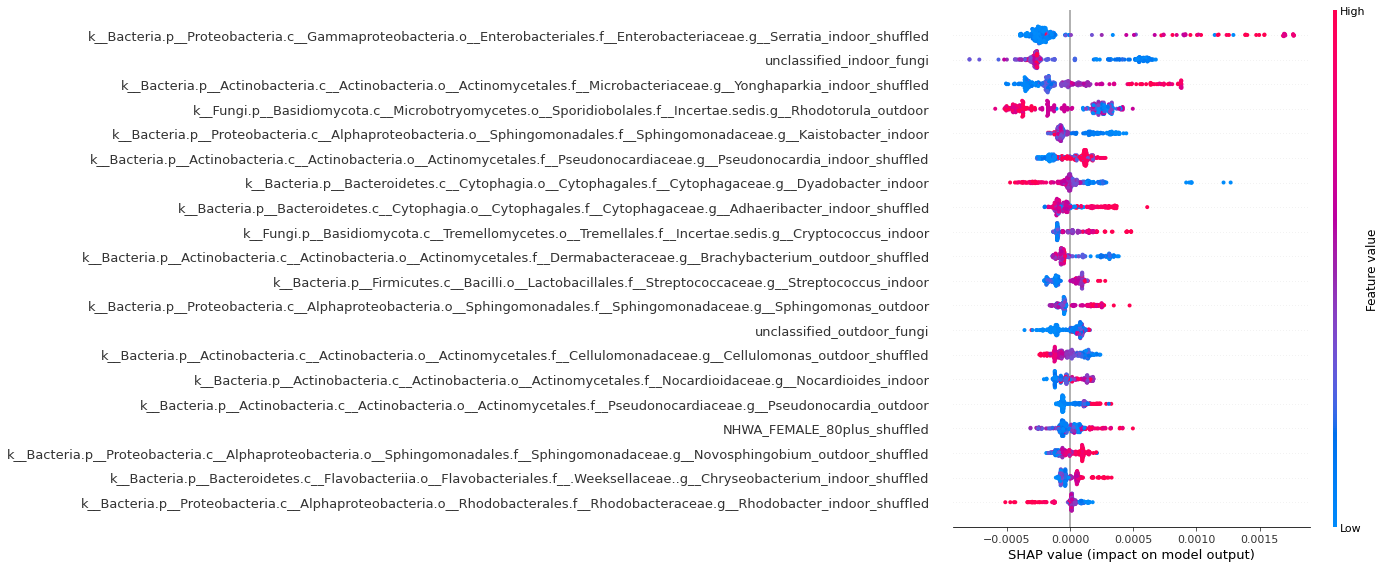

In [27]:
shap_values = explainer_fit.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')



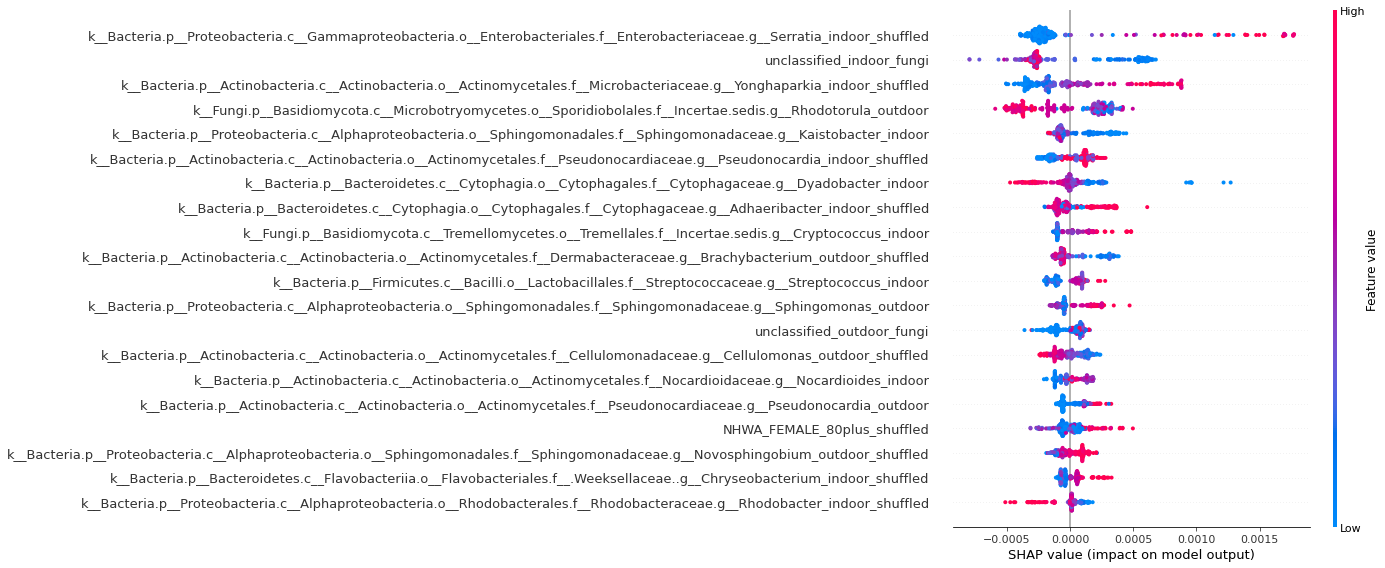

In [29]:
shap_values = explainer_model.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')




In [30]:
cbmf_all = cb_model.fit(X,y)

0:	learn: 0.0025606	total: 9.21ms	remaining: 9.2s
5:	learn: 0.0021514	total: 35.2ms	remaining: 5.83s
10:	learn: 0.0019021	total: 59.6ms	remaining: 5.36s
15:	learn: 0.0017483	total: 85.4ms	remaining: 5.25s
20:	learn: 0.0016366	total: 110ms	remaining: 5.11s
25:	learn: 0.0015688	total: 134ms	remaining: 5.01s
30:	learn: 0.0015083	total: 159ms	remaining: 4.97s
35:	learn: 0.0014639	total: 187ms	remaining: 5.01s
40:	learn: 0.0014222	total: 214ms	remaining: 5s
45:	learn: 0.0013886	total: 244ms	remaining: 5.07s
50:	learn: 0.0013572	total: 273ms	remaining: 5.08s
55:	learn: 0.0013284	total: 303ms	remaining: 5.11s
60:	learn: 0.0013014	total: 337ms	remaining: 5.19s
65:	learn: 0.0012684	total: 368ms	remaining: 5.21s
70:	learn: 0.0012392	total: 397ms	remaining: 5.2s
75:	learn: 0.0012049	total: 430ms	remaining: 5.23s
80:	learn: 0.0011711	total: 459ms	remaining: 5.21s
85:	learn: 0.0011453	total: 484ms	remaining: 5.14s
90:	learn: 0.0011192	total: 511ms	remaining: 5.11s
95:	learn: 0.0010930	total: 536ms	

830:	learn: 0.0001655	total: 4.37s	remaining: 889ms
835:	learn: 0.0001636	total: 4.4s	remaining: 863ms
840:	learn: 0.0001617	total: 4.42s	remaining: 836ms
845:	learn: 0.0001605	total: 4.45s	remaining: 810ms
850:	learn: 0.0001588	total: 4.47s	remaining: 784ms
855:	learn: 0.0001569	total: 4.5s	remaining: 757ms
860:	learn: 0.0001555	total: 4.53s	remaining: 731ms
865:	learn: 0.0001538	total: 4.55s	remaining: 704ms
870:	learn: 0.0001519	total: 4.58s	remaining: 678ms
875:	learn: 0.0001503	total: 4.6s	remaining: 652ms
880:	learn: 0.0001487	total: 4.63s	remaining: 625ms
885:	learn: 0.0001474	total: 4.65s	remaining: 599ms
890:	learn: 0.0001460	total: 4.68s	remaining: 573ms
895:	learn: 0.0001443	total: 4.72s	remaining: 547ms
900:	learn: 0.0001428	total: 4.75s	remaining: 522ms
905:	learn: 0.0001414	total: 4.78s	remaining: 496ms
910:	learn: 0.0001397	total: 4.81s	remaining: 470ms
915:	learn: 0.0001382	total: 4.84s	remaining: 444ms
920:	learn: 0.0001366	total: 4.87s	remaining: 418ms
925:	learn: 0.0

In [32]:
pred_all = cbmf_all.predict(X)
rmseA = (np.sqrt(mean_squared_error(y, pred_all)))
r2A = r2_score(y, pred_all)
print("All performance:")
print('RMSE training: {:.2f}'.format(rmseA))
print('R2 training: {:.2f}'.format(r2A))



All performance:
RMSE training: 0.00
R2 training: 1.00


In [33]:
explainer_all = shap.TreeExplainer(cbmf_all)

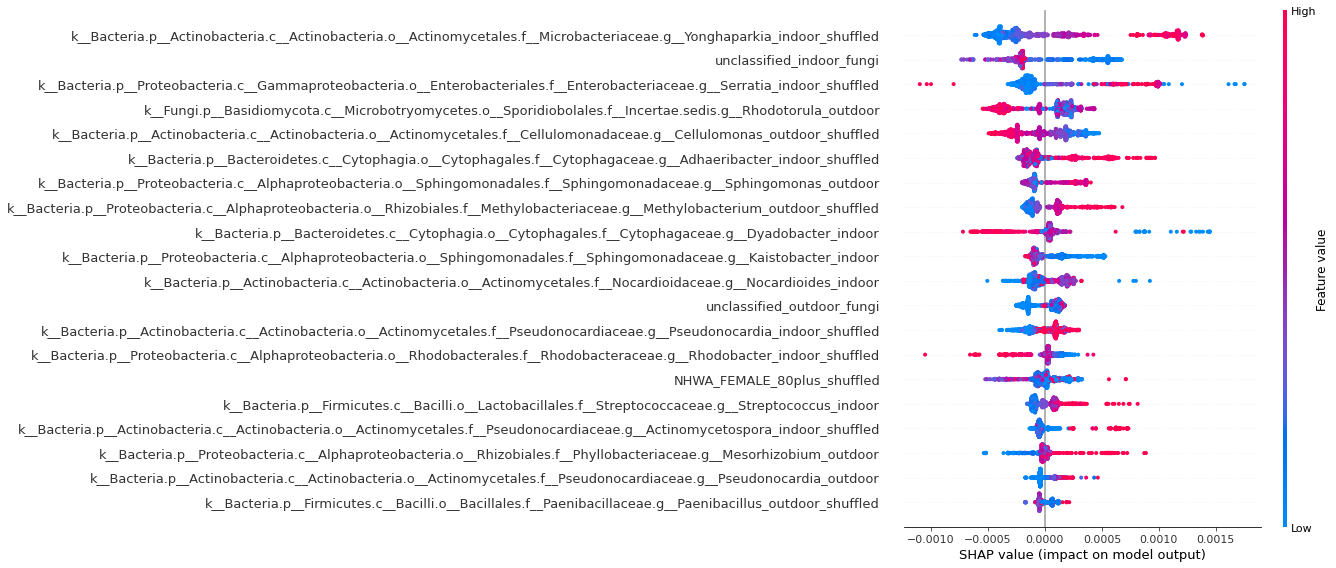

In [34]:
shap_values_all = explainer_all.shap_values(X)
shap.summary_plot(shap_values_all, X, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')
